In [4]:
cd '../'

/scratch/ssd001/home/ama/workspace/ama-at-vector/freq-robust


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import trange
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import grad
from src.attacks import pgd_rand
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# hyper params initalization
_batch_size = 128
_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
_lr_rate = 0.01
_momentum = 0.9
_epoch = 10

In [17]:
_batch_size = 1

data_train = datasets.CIFAR10("./data", train=True, download = True, transform=transforms.ToTensor())
data_test = datasets.CIFAR10("./data", train=False, download = True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(data_train, batch_size = _batch_size)
test_loader = torch.utils.data.DataLoader(data_test, batch_size = _batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
from models import ResNet8


path = "../test-bench-bat/exp/2021-01-16/resnet8_standard/model/model.pt"
model = ResNet8()
model.load_state_dict(torch.load(path, map_location=_device))
model.to(_device)
print("loaded")

loaded


In [30]:
total_3_fft = np.zeros((32,32), dtype = np.complex128)
num_3 = 0
total_7_fft = np.zeros((32,32), dtype = np.complex128)
num_7 = 0

with trange(len(train_loader)) as t:
    for X,y in train_loader:
        X, y = X.to(_device), y.to(_device)
        if y.item() == 3:
            delta = pgd_rand().generate(model,X,y)
            a = np.fft.fftshift(np.fft.fft2(delta.squeeze().mean(dim = 0).detach().cpu().numpy()))
            
            total_3_fft += a
            num_3 += 1
        elif y.item() == 7:
            delta = pgd_rand().generate(model,X,y)
            a = np.fft.fftshift(np.fft.fft2(delta.squeeze().mean(dim = 0).detach().cpu().numpy()))
            total_7_fft += a
            num_7 += 1
        t.update()
        
        if num_7 >100 and num_3 >100:
            break

mean_3_fft = total_3_fft/num_3
mean_7_fft = total_7_fft/num_7

  2%|▏         | 1060/50000 [00:27<20:52, 39.08it/s]


/h/ama/.conda/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
/h/ama/.conda/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/h/ama/.conda/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import k

Text(0.5, 1.0, "Log Mean Fourier Spectrum of 3's")

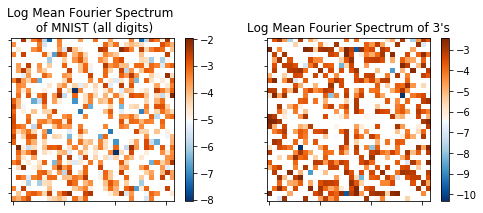

In [32]:
# blue: positive, red: negative
top = plt.cm.get_cmap('Blues', 128)
bottom = plt.cm.get_cmap('Oranges_r', 128)

newcolors = np.vstack((top(np.linspace(1, 0, 128)),
                       bottom(np.linspace(1, 0, 128))))
newcmp = colors.ListedColormap(newcolors, name='OrangeBlue')


fig_test = plt.figure(figsize = [13,3])
gs = fig_test.add_gridspec(1,3)
p1 = fig_test.add_subplot(gs[0,0]).imshow(np.log(np.real(mean_3_fft)), cmap = newcmp)
fig_test.colorbar(p1)
fig_test.add_subplot(gs[0,0]).set_yticklabels([])
fig_test.add_subplot(gs[0,0]).set_xticklabels([])
# fig_test.add_subplot(gs[0,0]).set_title('Log Mean Fourier Spectrum \n of MNIST:' + r'Log $\frac{1}{n}$ \Sigma F{x_{i}')
fig_test.add_subplot(gs[0,0]).set_title('Log Mean Fourier Spectrum \n of MNIST (all digits)')


p2 = fig_test.add_subplot(gs[0,1]).imshow(np.log(np.real(mean_7_fft)), cmap = newcmp)
fig_test.colorbar(p2)
fig_test.add_subplot(gs[0,1]).set_yticklabels([])
fig_test.add_subplot(gs[0,1]).set_xticklabels([])
fig_test.add_subplot(gs[0,1]).set_title('Log Mean Fourier Spectrum of 3\'s')

